# Homework 3: PySpark - II
### CS186, UC Berkeley, Spring 2016
### Due: Thursday Feb 25, 2016, 11:59 PM
### Note: **This homework is to be done individually!  Do not modify any existing method signatures.**
### **This is the second of two .ipynb files in this homework.

In [240]:
## On some computers it may be possible to run this lab 
## locally by using this script; you will need to run
## this each time you start the notebook.
## You do not need to run this on inst machines.

# from local_install import setup_environment
# setup_environment()

In [241]:
import pyspark
from utils import SparkContext as sc

In [242]:
from utils import CleanRDD
from utils import tests

# Part 3: CacheMap

In this part, we'll construct an rdd that is backed by a `ClockMap` and will behave like `rdd.map(func)`.  
First, implement the `ClockMap` class so that it maintains a cache (of limited `cacheSize`) using the clock replacement policy.

### * BEGIN STUDENT CODE *

In [243]:
class ClockMap:
    
    def __init__(self, cacheSize, func):
        """
        Do not change existing variables.
        [Optional] You are free to add additional items and methods.
        """
        self.cacheSize = cacheSize
        self.fn = func
        self._p = 0 # pointer
        self._increments = 0 # do not modify
        self._miss_count = 0 # do not modify
        self.buffers = [[None, 0] for x in range(cacheSize)]
        self.items_to_index = {}
        
    def _increment(self):
        """
        Do not change this method.
        Updates the clock pointer. The modulo maintains the clock nature.
        """
        self._increments += 1
        self._p = (self._p + 1) % self.cacheSize

    def __getitem__(self, k):
        """
        Returns func(k) using the buffer to cache limited results.
        
        :param k: Value to be evaluated
        
        >>> clock = ClockMap(4, lambda x: x ** 2)
        >>> clock[4]
        16
        >>> clock[3]
        9
        >>> clock._p
        2
        """
        index = self.items_to_index.get(k)
        if index != None:
            retval = self.buffers[index][0][1]
            self.buffers[index][1] = 1
            return retval

        while (self.buffers[self._p][0] != None and self.buffers[self._p][1] == 1):
            if len(self.items_to_index) >= self.cacheSize:
                self.buffers[self._p][1] = 0
            self._increment()
        
        retval = self.fn(k)
        if self.buffers[self._p][0] != None:
            old_key = self.buffers[self._p][0][0]
            del self.items_to_index[old_key]
        self.buffers[self._p] = [(k, retval), 1]
        self.items_to_index.update({k : self._p})
        self._increment()
        return retval
           

Now implement `cacheMap`, which will return an rdd.

In [244]:
def cacheMap(rdd, cacheSize, func):
    """
    Returns an RDD that behaves like rdd.map(func) but
    is implemented using the ClockMap.
    
    :param rdd: Given RDD
    :param cacheSize: Number of cache/buffer pages in the ClockMap
    :param func: Function to map with
    """
    def cacheFunc(pid, iterator):
        clock = ClockMap(cacheSize, func)
        for i in iterator:
            yield clock[i]
        
    return rdd.mapPartitionsWithIndex(cacheFunc)
    

### * END STUDENT CODE *

Free test for you!

In [245]:
clock = ClockMap(4, lambda x: x ** 2)
print clock[4], clock[3]
print clock._p

16 9
2


Output should be 
```
16, 9
2
```

# Part 4: External Algorithms

You'll need an understanding of the partitioning step of external hashing, and the divide step of external sorting (recall the lecture on external algorithms).

In [246]:
from utils import *
import itertools
import bisect
import os

The following are some tools you may want to use (examples use cases included). You should Google the unfamiliar ones!

In [247]:
# itertools.islice
generator = (y for y in range(100))
test1 = list(itertools.islice(generator, 5))

In [248]:
# heapq.merge
generator1 = (odd for odd in range(100) if odd % 2)
generator2 = (even for even in range(100)[::2])
key = lambda x: x
test2 = heapq.merge([generator1, generator2], key=key, reverse=False)
next(test2)

0

In [249]:
# bisect.bisect_left
buckets = [2, 4, 4]
print "If we insert 3, it goes to %d" % bisect.bisect_left(buckets, 3)
print "If we insert 1, it goes to %d" % bisect.bisect_left(buckets, 1)
print "If we insert 4, it goes to %d" % bisect.bisect_left(buckets, 4)

If we insert 3, it goes to 1
If we insert 1, it goes to 0
If we insert 4, it goes to 1


In [250]:
# RDD.sample
rdd = sc.parallelize(range(100))
fraction = 0.1
rdd.sample(False, fraction).collect()

[11, 18, 28, 41, 43, 54, 82]

In [251]:
# Serializer and os.unlink (Serializer is provided via utils.GeneralTools)
generator1 = (odd for odd in range(100) if odd % 2)
filename = "temp"
with open(filename, "w") as f:
    serializer.dump_stream(generator1, f)

with open(filename, "r") as f:
    stream = serializer.load_stream(f)
    print next(stream)

os.unlink(filename)

1


In [252]:
# get_used_memory - returns an int in MB
get_used_memory()

129

No need to modify the following function - it should come in handy!

In [253]:
def get_sort_dir(partId, n):
    """
    Returns a path for temporary file.

    :param n: Unique identification for file
    """
    d = "tmp/sort/" + str(partId) + "/"
    if not os.path.exists(d):
        os.makedirs(d)
    return os.path.join(d, str(n))

### * BEGIN STUDENT CODE *

In [254]:
def externalSortStream(iterator, partId=0, reverse=False, keyfunc=None, serial=serializer, limit=10, batch=100):
    """
    Given an iterator, returns an iterator of sorted elements (according to parameters). 
    :param iterator: iterator. Expects (Key, Value).
    :param keyfunc: function applied on the keykey.
    :param reverse: Reverse default ordering if true. (default is ascending; reverse is descending) 
    :param serializer: See README.
    :param limit: memory limit.
    :param batch: Number of elements to read at a time.
    """
    
    all_runs = [] # can be used to hold a list of iterators
    run = [] # used to hold the current run of elements
    
    def load(fileobj):
        """
        Returns a generator object that outputs elements 
        from a serialized (saved) stream. Closes the file when done.
        
        :param fileobj: python object file
        """
        for _ in serial.load_stream(fileobj):
            yield _
        fileobj.close()
        
    # TODO everywhere below 
    
    runID = 0
    while True:
        c = list(itertools.islice(iterator, batch))
        if len(c) != 0:
            run.extend(c)
            
        if len(c) == 0 and len(run) == 0:
            # print "Finished, let's stop."
            break
            
        if get_used_memory() >= limit: 
            run = sorted(run, key = lambda x: keyfunc(x[0]), reverse = reverse)
            # print "Buffer full, and the len of run is ", len(run)
            filename = get_sort_dir(partId, runID)
            f = open(filename, "w")
            serial.dump_stream(run, f)
            f.close()
            run = []
            runID += 1
            
        if not len(c) == 0 and len(run) > 0:
            run = sorted(run, key = lambda x: keyfunc(x[0]), reverse = reverse)
            # print "Buffer not full, reached end of file, len of run is ", len(run)
            filename = get_sort_dir(partId, runID)
            f = open(filename, "w")
            serial.dump_stream(run, f)
            f.close()
            runID += 1
            break
    
    for i in range(runID):
        f = get_sort_dir(partId, i)
        fname = open(f, "r")
        all_runs.append(load(fname)) 
        os.unlink(f)
        
    # print "There are a total of ", len(all_runs), " runs."
    return heapq.merge(all_runs, key=lambda x: keyfunc(x[0]), reverse=reverse)

In [255]:
# Remember to run the import box above.
def partitionByKey(rdd, ascending=True, numPartitions=None, keyfunc=lambda x: x):
    """        
    Uses sampling to partitions the elements by the return value of 
    keyfunc.

    :param ascending: Smallest first.
    :param numPartitions: Number of partitions of the returning RDD.
    :param keyfunc: function to be applied to the key.
    """
    # Base cases done.

    if numPartitions is None:
        numPartitions = rdd.getNumPartitions()

    if numPartitions == 1:
        if rdd.getNumPartitions() > 1:
            rdd = rdd.coalesce(1)
        return rdd
    
    # TODO
    buckets = getBuckets(rdd, ascending, numPartitions, keyfunc)
    boundaries = [x[0] for x in buckets]
    #     print "The buckets are ", buckets
    #     print
    #     print "The boundaries are ", boundaries
    #     print
    #     print "There are ",numPartitions,  " partitions"
    #     print
    
    if ascending:
        balanceLoad = lambda x : bisect.bisect_left(boundaries, keyfunc(x))
    if not ascending:
        balanceLoad= lambda x: numPartitions - 1 - bisect.bisect_left(boundaries, keyfunc(x))
    return rdd.partitionBy(numPartitions, balanceLoad)

def getBuckets(rdd, ascending=True, numPartitions=None, keyfunc=lambda x: x):
    """        
    [Optional] Returns a list of bucket boundaries of length (numPartitions - 1),
    in an order as specfied by the given parameters: ascending, keyfunc. 
    Bucket boundaries are determined by sampling as specified in the README.

    :param ascending: Smallest first.
    :param numPartitions: Number of partitions of the returning RDD.
    :param keyfunc: function to be applied to the key.
    """
    # Base cases done.
    fraction = 10 * float(numPartitions) / float(rdd.count())
    sample = rdd.sample(False, fraction).collect()
    sample.sort(key = lambda x: keyfunc(x[0]), reverse = not ascending)
    
    retval = []
    gap = len(sample)/numPartitions
    i = 0
    while i < numPartitions-1:
        retval.append(sample[gap*(i+1)-1])
        i += 1
    retval = retval[:numPartitions-1]
    return retval

In [256]:
def sortByKey(rdd, ascending=True, numPartitions=None, keyfunc=lambda x: x):
    """
    Returns an RDD after executing an external sort using 
    functions partitionByKey and externalSortStream. 

    :param ascending: Smallest first.
    :param numPartitions: Number of partitions of the returning RDD.
    :param keyFunc: function to be applied to the key.
    """
    part_rdd = partitionByKey(rdd, ascending, numPartitions, keyfunc)
    f = lambda pid, it : externalSortStream(it, partId = pid, reverse = not ascending, keyfunc = keyfunc)
    return part_rdd.mapPartitionsWithIndex(f)


### * END STUDENT CODE *

Here are tests for `partitionByKey` and `externalSortStream`:

In [257]:
test_stream = ((i, i) for i in range(100))
list(externalSortStream(test_stream, keyfunc=(lambda x: abs(50 - (x ** 2)))))[:10]

[(7, 7),
 (6, 6),
 (8, 8),
 (5, 5),
 (9, 9),
 (4, 4),
 (3, 3),
 (2, 2),
 (1, 1),
 (0, 0)]

Your output should be:
```
[(7, 7),
 (6, 6),
 (8, 8),
 (5, 5),
 (9, 9),
 (4, 4),
 (3, 3),
 (2, 2),
 (1, 1),
 (0, 0)]
```

In [258]:
rdd = CleanRDD(sc.parallelize(range(20), 4).map(lambda x: (x * 37 % 6, x ** 3 % 34)))
partitionByKey(rdd)


Your output should look rather well-distributed. Try forcing a skewed distribution and observe how effective the partitioning is.

Here's a test for `sortByKey`:

In [259]:
rdd = CleanRDD(sc.parallelize(range(100), 4).map(lambda x: (x *((-1) ** x) , x)))
sortByKey(rdd, keyfunc=lambda key: key, ascending=False).collect()[-10:] 

[(-81, 81),
 (-83, 83),
 (-85, 85),
 (-87, 87),
 (-89, 89),
 (-91, 91),
 (-93, 93),
 (-95, 95),
 (-97, 97),
 (-99, 99)]

Your output should be:
```
[(-81, 81),
 (-83, 83),
 (-85, 85),
 (-87, 87),
 (-89, 89),
 (-91, 91),
 (-93, 93),
 (-95, 95),
 (-97, 97),
 (-99, 99)]
```

# Testing

In [260]:
tests.test3ClockMap(ClockMap)
tests.test3CacheMap(cacheMap)
tests.test4(sortByKey)

Task 3: PASS - task3ClockMap.txt matched reference output.
Task 3: PASS - task3CacheMap.txt matched reference output.
Task 4: PASS - task4.txt matched reference output.


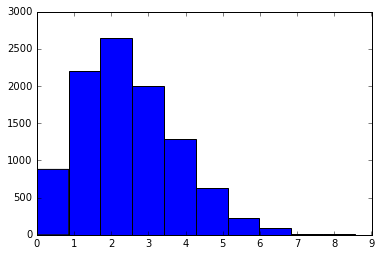

In [261]:
import numpy as np
random.seed(22222222)
x_ray = np.random.rayleigh(scale = 2, size = (10000))
% matplotlib inline
import matplotlib.pyplot as plt

plt.hist(x_ray)
plt.show()


In [262]:
rdd = CleanRDD(sc.parallelize(x_ray, 10).map(lambda x: (x,0)))
rdd2 = sortByKey(rdd, keyfunc = lambda key: key, ascending = False)
print rdd2.collect()[:30]
print
rdd3 = rdd2.mapPartitionsWithIndex(lambda pid, iterat : ((pid, i) for i in iterat))
print rdd3.collect()[-10:]
rdd3.count()

[(8.5443722562751461, 0), (8.4801527420648029, 0), (8.3128699694286379, 0), (8.2504516811009765, 0), (8.0929400093602482, 0), (7.9330277173674997, 0), (7.8890028915201853, 0), (7.8630512485823205, 0), (7.8511484633263091, 0), (7.8507906329163193, 0), (7.8499028990414965, 0), (7.8473015613031025, 0), (7.6739014147318834, 0), (7.6473713512817607, 0), (7.3439882430236381, 0), (7.3114423529534971, 0), (7.3026249366742295, 0), (7.2074037685434611, 0), (7.1743138923592022, 0), (7.1360496309319696, 0), (7.0539159799626256, 0), (7.0065660310818201, 0), (7.0057528290535931, 0), (6.9478709113765191, 0), (6.9283582547404974, 0), (6.9236583760294259, 0), (6.8833912435210625, 0), (6.8736585522622251, 0), (6.8459823662715014, 0), (6.8361931029337919, 0)]

[(9, (0.081877592267981927, 0)), (9, (0.075670608422066868, 0)), (9, (0.075113288763272099, 0)), (9, (0.074563174710255975, 0)), (9, (0.071188784829067708, 0)), (9, (0.071155477848711665, 0)), (9, (0.054709298203002091, 0)), (9, (0.0500834359910577

10000

In [263]:
rdd = CleanRDD(sc.parallelize(range(20), 4).map(lambda x: (x * 37 % 6, x ** 3 % 34)))

temp = partitionByKey(rdd, ascending = False)
print temp.getNumPartitions()
def checkit(rdd):
    def p(n, itr):
        for i in itr:
            yield (n, i)
    return rdd.mapPartitionsWithIndex(p).collect()

checkit(temp)

4


[(0, (3, 27)),
 (0, (4, 30)),
 (0, (5, 23)),
 (0, (3, 15)),
 (0, (4, 14)),
 (0, (5, 5)),
 (0, (3, 9)),
 (0, (4, 16)),
 (0, (5, 17)),
 (3, (0, 0)),
 (3, (1, 1)),
 (3, (2, 8)),
 (3, (0, 12)),
 (3, (1, 3)),
 (3, (2, 2)),
 (3, (0, 28)),
 (3, (1, 21)),
 (3, (2, 24)),
 (3, (0, 18)),
 (3, (1, 25))]